In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

from tqdm import tqdm
import glob
import sys

ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
import h3
import geopandas as gpd
import shapely

In [102]:
ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_pano.csv"
PATH_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_path.csv"
CURATED_FOLDER = f"{ROOTFOLDER}/_curated"
VITALITY_FOLDER = os.path.join(CURATED_FOLDER, "c_object_longitudinal")
VITALITY_HEX_FOLDER = os.path.join(CURATED_FOLDER, "c_object_hex")
if not os.path.exists(VITALITY_HEX_FOLDER):
    os.makedirs(VITALITY_HEX_FOLDER)
VITALITY_FILE_NAME = "c_object_res={res}_{cityabbr}.csv"
files = glob.glob(f"{VITALITY_FOLDER}/*.csv")
print("Total files: ", len(files))

Total files:  762


In [34]:
YEAR_GROUP = ['<2014','2014-2015','2016-2017','2018-2019', '2020-2021','2022-2023']
column_map = {
    "<2014":[2007,   2008,   2009,   2010,   2011,   2012,   2013,],
    "2014-2015":[2014, 2015],
    "2016-2017":[2016, 2017],
    "2018-2019":[2018, 2019],
    "2020-2021":[2020, 2021],
    "2022-2023":[2022, 2023, 2024]
    
}

In [5]:
city_meta = pd.read_csv("../city_meta.csv")
city_meta['cityabbr'] = city_meta['City'].str.lower().str.replace(" ", "")

In [90]:
def merge_vitality_data(res=8):
    df_v = []
    for cityabbr in city_meta['cityabbr']:

        try:
            file_name = VITALITY_FILE_NAME.format(res=res, cityabbr=cityabbr)
            df = pd.read_csv(os.path.join(VITALITY_FOLDER, file_name))  
            df['cityabbr'] = cityabbr
            df['res'] = res
            df_v.append(df)
        except:
            # print(f"Error reading {cityabbr} res={res}")
            continue
    df_v = pd.concat(df_v, axis = 0).reset_index(drop=True)
    df_v.to_parquet(f"{VITALITY_FOLDER}/c_object_res={res}_all.parquet")
    return df_v

In [91]:
for res in [8,9,12]:
    merge_vitality_data(res) # run later

/tmp/ipykernel_3296683/3855737635.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_v = pd.concat(df_v, axis = 0).reset_index(drop=True)
/tmp/ipykernel_3296683/3855737635.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_v = pd.concat(df_v, axis = 0).reset_index(drop=True)
/tmp/ipykernel_3296683/3855737635.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns w

In [116]:
res = 12
df_v =pd.read_parquet(f"{VITALITY_FOLDER}/c_object_res={res}_all.parquet")
df_v['year'] = df_v['year'].astype(int)
# create year group
for k,v in column_map.items():
    df_v.loc[df_v['year'].isin(v), 'year_group'] = k

df_v['year_group'].value_counts()

year_group
2022-2023    11859317
2018-2019     9698997
2020-2021     7105944
2016-2017     5725792
2014-2015     3913644
Name: count, dtype: int64

In [117]:

df_v_group  = df_v.groupby(['year_group','cityabbr','hex_id','object_name']).agg({
    'n':'sum',
    'panoid_n':'sum',
}).reset_index()
df_v_group.head()


,year_group,cityabbr,hex_id,object_name,n,panoid_n
0,2014-2015,amsterdam,8c19682080033ff,car,19.0,1
1,2014-2015,amsterdam,8c19682080093ff,car,11.0,1
2,2014-2015,amsterdam,8c19682080093ff,motorcycle,2.0,1
3,2014-2015,amsterdam,8c19682080093ff,person,2.0,1
4,2014-2015,amsterdam,8c19682080167ff,bicycle,1.0,1


In [ ]:
gc.collect()

In [118]:
# experiment 1: only keep the hex_id that have images in all years
year_group_included = YEAR_GROUP[2:]
df_v_group_filtered = df_v_group[df_v_group['year_group'].isin(year_group_included)].reset_index(drop = True)
all_hex_df = df_v_group_filtered[['hex_id','cityabbr','year_group','panoid_n']].drop_duplicates().reset_index(drop = True)

all_hex_df['n_year_group'] = all_hex_df.groupby(['cityabbr','hex_id'])['year_group'].transform('nunique')
all_hex_df['keep'] = all_hex_df['n_year_group'] == len(year_group_included)

full_hex_df = all_hex_df[all_hex_df['keep']==True][['year_group','cityabbr','hex_id','panoid_n']]
print("Number of cities available: ", full_hex_df['cityabbr'].nunique())

In [115]:
for object_name in df_v_group['object_name'].unique():
    df_object = full_hex_df.merge(df_v_group[df_v_group['object_name'] == object_name][['n','cityabbr','hex_id','year_group']], 
                                on = ['cityabbr','hex_id','year_group'], how = 'left').fillna(0)
    # step 1. without balancing the hex_id. simply plot the change of number of person observed per hex_id per city
    df_object['n_per_pano'] = df_object['n']/df_object['panoid_n']
    df_object.to_parquet(f"{VITALITY_HEX_FOLDER}/c_object_res={res}_{object_name}.parquet")
    print(f"Saved {object_name} to {VITALITY_HEX_FOLDER}/c_object_res={res}_{object_name}.parquet")

Saved bench to /lustre1/g/geog_pyloo/05_timemachine/_curated/c_object_hex/c_object_res=8_bench.parquet
Saved bicycle to /lustre1/g/geog_pyloo/05_timemachine/_curated/c_object_hex/c_object_res=8_bicycle.parquet
Saved bus to /lustre1/g/geog_pyloo/05_timemachine/_curated/c_object_hex/c_object_res=8_bus.parquet
Saved car to /lustre1/g/geog_pyloo/05_timemachine/_curated/c_object_hex/c_object_res=8_car.parquet
Saved motorcycle to /lustre1/g/geog_pyloo/05_timemachine/_curated/c_object_hex/c_object_res=8_motorcycle.parquet
Saved person to /lustre1/g/geog_pyloo/05_timemachine/_curated/c_object_hex/c_object_res=8_person.parquet
Saved stop sign to /lustre1/g/geog_pyloo/05_timemachine/_curated/c_object_hex/c_object_res=8_stop sign.parquet
Saved truck to /lustre1/g/geog_pyloo/05_timemachine/_curated/c_object_hex/c_object_res=8_truck.parquet
Saved traffic light to /lustre1/g/geog_pyloo/05_timemachine/_curated/c_object_hex/c_object_res=8_traffic light.parquet
Saved chair to /lustre1/g/geog_pyloo/05_t

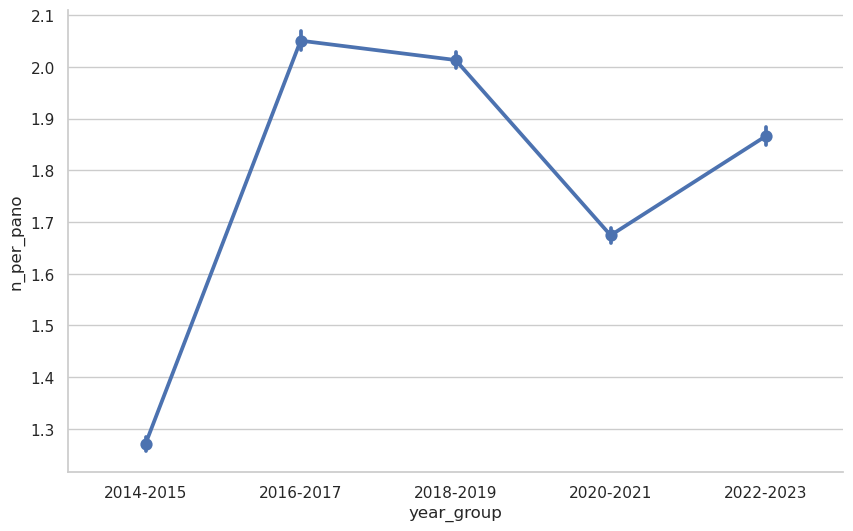

In [107]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.pointplot(data=df_object, 
              x='year_group', 
              y='n_per_pano', 
            #   hue='cityabbr', 
              # dodge=True, ci='sd'
              )
sns.despine()